In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch
import torch.nn.functional as F

## Data Pre-processing

In [51]:
BitCoin = pd.read_csv('1_Bitcoin.csv')
BitCoin=BitCoin.applymap(lambda x: x.replace('$',''))
BitCoin=BitCoin.applymap(lambda x: x.replace(',',''))
cl = ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']
for c in cl:
    BitCoin[c] = BitCoin[c].astype(float)
MarketData = pd.read_excel('MarketData.xlsx') 
BitCoin['SP500'] = MarketData['S&P_processed'].values
# BitCoin = BitCoin[:1460]

BitCoin = BitCoin.rename(columns={'Open*': 'Open', 'Close**': 'Close'})
data_l = len(BitCoin)
BitCoin = BitCoin[data_l::-1]

In [52]:
BitCoin.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap,SP500
3041,Jul 02 2013,88.05,92.30,87.51,90.13,0.0,1.024082e+09,4605.38
3040,Jul 03 2013,90.40,90.98,76.98,77.53,0.0,8.812331e+08,4596.42
3039,Jul 04 2013,78.89,83.11,72.00,80.53,0.0,9.156186e+08,4551.68


In [53]:
BitCoin.tail()

,Date,Open,High,Low,Close,Volume,Market Cap,SP500
4,Oct 25 2021,60893.93,63729.33,60691.80,63039.83,3.106491e+10,1.188575e+12,1631.89
3,Oct 26 2021,63032.76,63229.03,59991.16,60363.79,3.487897e+10,1.138178e+12,1631.89
2,Oct 27 2021,60352.00,61435.18,58208.19,58482.39,4.365708e+10,1.102758e+12,1615.41
1,Oct 28 2021,58470.73,62128.63,58206.92,60622.14,4.525708e+10,1.143166e+12,1615.41
0,Oct 29 2021,60624.87,62927.61,60329.97,62227.96,3.685688e+10,1.173512e+12,1614.08


In [54]:
BitCoin.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap',
       'SP500'],
      dtype='object')

In [55]:
# Data = BitCoin[['Close','Open','High', 'Low', 'Volume','SP500']]
Data = BitCoin[['Close','Open','High', 'Low', 'Volume']]
in_dim = len(Data.columns)
# Time series length
time_stamp = 5 

# Seperate training, validating, testing dataset
P = BitCoin[['Close','High', 'Low', 'Volume']]
split_1 = int(len(Data) * 0.6)
split_2 = int(len(Data) *0.8)

train = Data[0:split_1+time_stamp]
valid = Data[split_1:split_2 + time_stamp]
test = Data[split_2 :]

In [56]:
# Normalization

scaler = MinMaxScaler()

def data_processing(data, time_stamp):
    min_ = data['Close'].min()
    max_ = data['Close'].max()
    scaled_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(time_stamp, len(data)-time_stamp):
        x.append(scaled_data[i-time_stamp:i,:])
        y.append(scaled_data[i,0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], in_dim))
#     print(x.shape)
#     print(y.shape)
    return x,y,max_,min_

x_train, y_train, max_train, min_train = data_processing(train, time_stamp)
x_valid, y_valid,max_valid, min_valid  = data_processing(valid, time_stamp)
x_test, y_test,max_test, min_test   = data_processing(test, time_stamp)

In [57]:
# Build function to make dataset for pytorch
class PriceDataset(Dataset):
    def __init__(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def __len__(self):
        return len(x_train)
    
    def __getitem__(self, index):
        return x_train[index], y_train[index]

def makeloader(dataset,batch_size):
    
    loader = DataLoader(dataset, batch_size, shuffle = True)
    return loader

In [58]:
# Make dataset
batch_size = 32

dataset =  PriceDataset(x_train, y_train)
loader = makeloader(dataset, batch_size)

val_dataset =  PriceDataset(x_valid, y_valid)
val_loader = makeloader(val_dataset, batch_size)

test_dataset =  PriceDataset(x_test, y_test)
test_loader = makeloader(test_dataset, batch_size)


# TESTING
for batch_x, batch_y in loader:
    print(batch_x[0][0])
    print(batch_y.shape)
    break
    
dataset.x_train.shape

tensor([0.0266, 0.0261, 0.0256, 0.0269, 0.0030], dtype=torch.float64)
torch.Size([32])


(1820, 5, 5)

## Model

In [59]:
# Building the Hybrid model
class CNN(nn.Module):

    def __init__(self, input_dim,hidden_dim,out_dim):
        super(CNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.cov_1 = nn.Conv1d(input_dim,64,1)     #CONV1D
        self.incept_1 = nn.Conv1d(64, 64, 1) # inception layers
        self.incept_2 = nn.Conv1d(64, 64, 3) # inception layers
        self.incept_3 = nn.Conv1d(64, 64, 5) # inception layers
        self.fc1 = nn.Linear(64,448) # FC
        self.fc2 = nn.Linear(448,32) # FC
        self.fc3 = nn.Linear(32, 16) # FC
        self.fc4 = nn.Linear(16, 1) # FC
    def forward(self, x_train):
        #       CONV1D  
        conv_1 = F.relu(self.cov_1(x_train.permute(0,2,1)))
        #       INCEPTION Layer (GOOGLENET)
        incept_1 = F.relu(self.incept_1(conv_1))
        incept_2 = F.relu(self.incept_2(conv_1))
        incept_3 = F.relu(self.incept_3(conv_1))
        cat = torch.cat((conv_1,incept_1, incept_2, incept_3), 2)
        #       Fully Connected Layers
        fc_out1 =  self.fc1(cat.permute(0,2,1))
        fc_out2=  self.fc2(fc_out1)
        fc_out3 =  self.fc3(fc_out2)
        out =  self.fc4(fc_out3 )
        return out

In [60]:
model=CNN(in_dim,64,1)
print(model)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

CNN(
  (cov_1): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
  (incept_1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (incept_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (incept_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=448, bias=True)
  (fc2): Linear(in_features=448, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [61]:
epoch = 300

# Initialize 2 lists for storing MAPE loss
Train_MAPE_list = np.zeros(epoch)
Valid_MAPE_list = np.zeros(epoch)

for epoch in range(epoch):     
       #     ====== TRAIN  ====== #
    model.train()
    total_loss = []
    for batch_x, batch_y in loader:
        model.zero_grad() # Clear them out Pytorch accumulated gradients before each instance
        out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
#         out = model(torch.tensor(batch_x).float()) # Run forward pass.
        loss =abs (((out - batch_y.float())*(max_train - min_train))/(batch_y.float()*(max_train - min_train)+min_train))
        loss = torch.mean(loss)
        loss.backward()
        optimizer.step()
        total_loss.append(loss)
    Train_MAPE = sum(total_loss)/len(total_loss)

    #     ====== VALID  ====== #
    model.eval()
    total_loss = []
    for batch_x, batch_y in val_loader:
            model.zero_grad()
#             out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1)
            out = model(torch.tensor(batch_x).float())
            loss =abs (((out - batch_y.float())*(max_valid- min_valid))/((batch_y.float()*(max_valid - min_valid)+min_valid)))
            loss = torch.mean(loss)
            total_loss.append(loss)
    Valid_MAPE=sum(total_loss)/len(total_loss)
    
    print("Iter %d ,Train MAPE: %.5f, Valid MAPE: %.5f"%(epoch+1 ,Train_MAPE, Valid_MAPE))
    Train_MAPE_list[epoch] = Train_MAPE
    Valid_MAPE_list[epoch] = Valid_MAPE

<ipython-input-61-1a31da8a1340>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
<ipython-input-61-1a31da8a1340>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())


Iter 1 ,Train MAPE: 2.23744, Valid MAPE: 0.15718
Iter 2 ,Train MAPE: 0.59920, Valid MAPE: 0.15132
Iter 3 ,Train MAPE: 0.52990, Valid MAPE: 0.15412
Iter 4 ,Train MAPE: 0.41402, Valid MAPE: 0.16281
Iter 5 ,Train MAPE: 0.19795, Valid MAPE: 0.17581
Iter 6 ,Train MAPE: 0.11756, Valid MAPE: 0.17096
Iter 7 ,Train MAPE: 0.09631, Valid MAPE: 0.16773
Iter 8 ,Train MAPE: 0.09026, Valid MAPE: 0.16902
Iter 9 ,Train MAPE: 0.07653, Valid MAPE: 0.16647
Iter 10 ,Train MAPE: 0.06268, Valid MAPE: 0.16647
Iter 11 ,Train MAPE: 0.07594, Valid MAPE: 0.16615
Iter 12 ,Train MAPE: 0.07414, Valid MAPE: 0.16634
Iter 13 ,Train MAPE: 0.07661, Valid MAPE: 0.16550
Iter 14 ,Train MAPE: 0.07856, Valid MAPE: 0.16648
Iter 15 ,Train MAPE: 0.07127, Valid MAPE: 0.16653
Iter 16 ,Train MAPE: 0.09185, Valid MAPE: 0.16612
Iter 17 ,Train MAPE: 0.06873, Valid MAPE: 0.16509
Iter 18 ,Train MAPE: 0.06182, Valid MAPE: 0.16677
Iter 19 ,Train MAPE: 0.08280, Valid MAPE: 0.16508
Iter 20 ,Train MAPE: 0.07420, Valid MAPE: 0.16483
Iter 21 ,

Iter 164 ,Train MAPE: 0.04784, Valid MAPE: 0.16915
Iter 165 ,Train MAPE: 0.04947, Valid MAPE: 0.16731
Iter 166 ,Train MAPE: 0.05402, Valid MAPE: 0.16761
Iter 167 ,Train MAPE: 0.05002, Valid MAPE: 0.16769
Iter 168 ,Train MAPE: 0.05357, Valid MAPE: 0.16808
Iter 169 ,Train MAPE: 0.05134, Valid MAPE: 0.16843
Iter 170 ,Train MAPE: 0.05255, Valid MAPE: 0.16874
Iter 171 ,Train MAPE: 0.04650, Valid MAPE: 0.16738
Iter 172 ,Train MAPE: 0.05045, Valid MAPE: 0.16837
Iter 173 ,Train MAPE: 0.04937, Valid MAPE: 0.16812
Iter 174 ,Train MAPE: 0.05632, Valid MAPE: 0.16755
Iter 175 ,Train MAPE: 0.05064, Valid MAPE: 0.16791
Iter 176 ,Train MAPE: 0.05035, Valid MAPE: 0.16778
Iter 177 ,Train MAPE: 0.05323, Valid MAPE: 0.16746
Iter 178 ,Train MAPE: 0.04961, Valid MAPE: 0.16760
Iter 179 ,Train MAPE: 0.05473, Valid MAPE: 0.16850
Iter 180 ,Train MAPE: 0.05239, Valid MAPE: 0.16862
Iter 181 ,Train MAPE: 0.05394, Valid MAPE: 0.16741
Iter 182 ,Train MAPE: 0.05042, Valid MAPE: 0.16487
Iter 183 ,Train MAPE: 0.06010, 

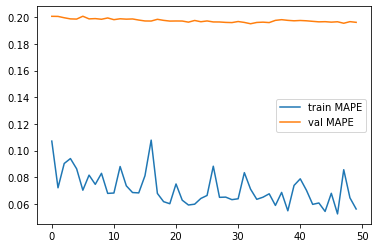

In [13]:
x_axis = np.arange(50)
plt.plot(x_axis, Train_MAPE_list[10:60], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[10:60], label='val MAPE')
plt.legend()
plt.show()

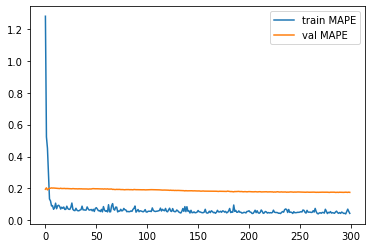

In [14]:
x_axis = np.arange(epoch+1)
plt.plot(x_axis, Train_MAPE_list[:], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[:], label='val MAPE')
plt.legend()
plt.show()

In [49]:
## test performance on the test set and report final performance
X_test_tensor =  torch.tensor(x_test).float()
y_test_pred = model(X_test_tensor).float()[:,-1,:].reshape(-1).detach().numpy()
y_test_pred_inverse = y_test_pred*(max_test - min_test)+min_test
# print("shape of test_y_pred:   ",y_test_pred_inverse.shape)
y_test_invesre = y_test*(max_test - min_test)+min_test


test_MAPE=sum(abs ((y_test_invesre - y_test_pred_inverse)/y_test_invesre))/len(y_test_invesre)
print("The mean absolute percentage error for the CNN is: %2f"%test_MAPE)


The mean absolute percentage error for the CNN is: 0.046337


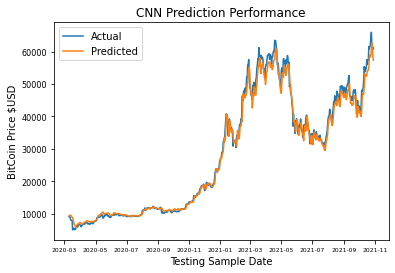

In [47]:
date = np.array(BitCoin[2443:]['Date'])
x_axis = date
plt.plot(x_axis, y_test_invesre, label='Actual')
plt.plot(x_axis, y_test_pred_inverse, label='Predicted')
plt.tick_params(axis = 'x', labelsize = 6)
plt.tick_params(axis = 'y', labelsize = 8)
plt.xlabel('Testing Sample Date')
plt.ylabel('BitCoin Price $USD')
plt.title("CNN Prediction Performance")
plt.legend()
plt.show()

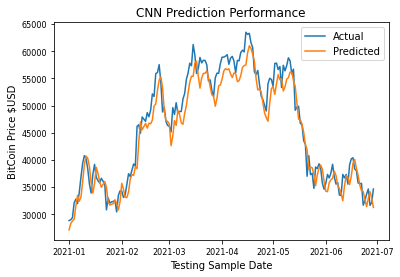

In [45]:
BitCoin['Date']=pd.to_datetime(BitCoin['Date'])
date = np.array(BitCoin[2740:2920]['Date'])
x_axis = date
plt.plot(x_axis, y_test_invesre[300:480], label='Actual')
plt.plot(x_axis, y_test_pred_inverse[300:480], label='Predicted')
plt.tick_params(axis = 'x', labelsize = 8)
plt.tick_params(axis = 'y', labelsize = 8)
plt.xlabel('Testing Sample Date')
plt.ylabel('BitCoin Price $USD')
plt.title("CNN Prediction Performance")
plt.legend()
plt.show()
